In [49]:
# !conda install scipy -y

In [50]:
import numpy as np
import os
from utilities import *
import h5py
from scipy.stats import zscore

# Use os.path.join() to create the correct file path
filepath = get_filepath()
print(f"Base filepath: {filepath}")

Base filepath: /Users/jesseh/Library/Mobile Documents/com~apple~CloudDocs/AA Master AI/Deep Learning


In [51]:
def load_and_normalize_files(directory_path, max_files=None, downsample_factor=None):
    """
    Load and normalize all h5 files in the specified directory
    
    Parameters:
    directory_path (str): Path to the directory containing h5 files
    max_files (int, optional): Maximum number of files to load
    downsample_factor (int, optional): Factor by which to downsample the data
    
    Returns:
    tuple: (data, labels) where data is a list of normalized matrices and labels are the corresponding task types
    """
    data_list = []
    labels = []
    
    # Get all h5 files in the directory
    h5_files = [f for f in os.listdir(directory_path) if f.endswith('.h5')]
    
    # Limit the number of files if specified
    if max_files is not None:
        h5_files = h5_files[:max_files]
    
    for file in h5_files:
       # Extract the task type from the filename
        if file.startswith("task_"):
            parts = file.split('_')
            task_type = '_'.join(parts[:2])  # e.g., task_motor or task_working
        else:
            task_type = file.split('_')[0]  # e.g., rest

        # Load the data
        file_path = os.path.join(directory_path, file)
        matrix = read_h5py_file(file_path)
        
        # Downsample if specified
        if downsample_factor is not None:
            matrix = matrix[:, ::downsample_factor]
        
        # Normalize the data using scipy's zscore
        normalized_matrix = zscore(matrix, axis=1, nan_policy='propagate')
        normalized_matrix = np.nan_to_num(normalized_matrix, nan=0.0)
        
        # Add to lists
        data_list.append(normalized_matrix)
        labels.append(task_type)
    
    return data_list, labels

# Example usage for Intra-subject classification
intra_train_path = os.path.join(filepath, "Intra", "train")
intra_test_path = os.path.join(filepath, "Intra", "test")

# Load a small subset of files to test the function
# Downsample factor is set to 16 to speed up the process, CHANGE LATER!
train_data, train_labels = load_and_normalize_files(intra_train_path, downsample_factor=16)
test_data, test_labels = load_and_normalize_files(intra_test_path, downsample_factor=16)
unique_labels = set(train_labels + test_labels)
print(f"Unique labels: {unique_labels}")

# Print summary
print(f"\nLoaded {len(train_data)} training files and {len(test_data)} test files")
print(f"Training labels: {train_labels}")
print(f"Test labels: {test_labels}")
print(f"Shape of first training sample after downsampling: {train_data[0].shape}")



Unique labels: {'task_motor', 'task_story', 'task_working', 'rest'}

Loaded 32 training files and 8 test files
Training labels: ['rest', 'task_story', 'task_motor', 'task_story', 'task_story', 'task_working', 'task_motor', 'rest', 'rest', 'task_working', 'task_motor', 'rest', 'task_motor', 'task_working', 'task_motor', 'rest', 'rest', 'task_motor', 'task_working', 'task_story', 'task_motor', 'task_working', 'task_motor', 'task_working', 'rest', 'rest', 'task_working', 'task_story', 'task_story', 'task_story', 'task_working', 'task_story']
Test labels: ['task_motor', 'rest', 'task_story', 'task_working', 'task_motor', 'task_story', 'task_working', 'rest']
Shape of first training sample after downsampling: (248, 2227)


In [ ]:
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
# Standard class mapping for MEG tasks

LABEL_MAP = {
    'rest': 0,
    'task_motor': 1, 
    'task_story': 2,
    'task_working': 3
}

class MEGDataset(Dataset):
    """Custom Dataset for MEG data"""
    def __init__(self, data_list, labels):
        self.data_list = data_list
        self.labels = labels
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        # Get the data matrix (248, time_steps)
        data = self.data_list[idx]
        
        # Add channel dimension: (248, time_steps) -> (1, 248, time_steps)
        data = torch.FloatTensor(data).unsqueeze(0)
        
        # Convert string label to integer
        label = LABEL_MAP[self.labels[idx]]
        label = torch.LongTensor([label]).squeeze()
        
        return data, label

class MEGNet(nn.Module):
    """Smaller 2D CNN for MEG data classification"""
    def __init__(self, num_classes=4, input_channels=248, input_time_steps=2227):
        super(MEGNet, self).__init__()
        
        # Smaller conv blocks
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(8, 16), padding=(4, 8))
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 8))  # More aggressive pooling
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(4, 8), padding=(2, 4))
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=(4, 8))  # More aggressive pooling
        
        # Calculate the size after convolutions
        self.flatten_size = self._calculate_flatten_size(input_channels, input_time_steps)
        
        # Smaller fully connected layers
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def _calculate_flatten_size(self, channels, time_steps):
        """Calculate the size after all conv+pool operations"""
        # Simulate forward pass to get dimensions
        x = torch.zeros(1, 1, channels, time_steps)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        return x.numel()
    
    def forward(self, x):
        # Conv blocks with ReLU and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Flatten for fully connected layers
        x = torch.flatten(x, 1)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
class TinyMEGNet(nn.Module):
    """Very small CNN for limited MEG data"""
    def __init__(self, num_classes=4, input_channels=248, input_time_steps=2227):
        super(TinyMEGNet, self).__init__()
        
        # Aggressive downsampling with minimal parameters
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(32, 64), stride=(8, 16))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(4, 8), stride=(2, 4))
        
        # Global average pooling instead of large FC layers
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Minimal fully connected
        self.fc = nn.Linear(8, num_classes)
        self.dropout = nn.Dropout(0.5)
        
        print(f"TinyMEGNet created with {sum(p.numel() for p in self.parameters()):,} parameters")
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        return x
    
class CNNLSTMNet(nn.Module):
    """
    Hybrid CNN+LSTM model for MEG classification
    
    Architecture:
    1. CNN layers extract spatial features from MEG channels
    2. Reshape CNN output into temporal sequences 
    3. LSTM processes temporal dependencies
    4. Final classification layer
    """
    def __init__(self, num_classes=4, input_channels=248, input_time_steps=2227, 
                 lstm_hidden_size=64, num_lstm_layers=2, dropout=0.3):
        super(CNNLSTMNet, self).__init__()
        
        self.input_channels = input_channels
        self.input_time_steps = input_time_steps
        
        # Step 1: CNN for spatial feature extraction
        # Use 1D convolutions along the channel dimension to extract spatial patterns
        self.spatial_conv = nn.Sequential(
            # First conv: reduce channel dimension while preserving time
            nn.Conv2d(1, 16, kernel_size=(16, 1), stride=(4, 1), padding=(6, 0)),  # Channels: 248->~62
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            
            # Second conv: further spatial reduction
            nn.Conv2d(16, 32, kernel_size=(8, 1), stride=(2, 1), padding=(3, 0)),  # Channels: ~62->~31
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            
            # Third conv: final spatial features
            nn.Conv2d(32, 64, kernel_size=(4, 1), stride=(2, 1), padding=(1, 0)),  # Channels: ~31->~16
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        # Calculate the spatial output size after convolutions
        self._calculate_conv_output_size()
        
        # Step 2: Temporal convolution to create meaningful time segments
        # Use 1D conv along time dimension to downsample and create feature sequences
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(self.spatial_features, 128, kernel_size=16, stride=8, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Conv1d(128, 64, kernel_size=8, stride=4, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        
        # Calculate temporal output size
        self._calculate_temporal_output_size()
        
        # Step 3: LSTM for temporal sequence modeling
        self.lstm = nn.LSTM(
            input_size=64,  # Features from temporal conv
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0,
            bidirectional=True  # Use bidirectional LSTM for better context
        )
        
        # Step 4: Classification head
        # Bidirectional LSTM doubles the hidden size
        lstm_output_size = lstm_hidden_size * 2
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_size, lstm_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_size, num_classes)
        )
        
        print(f"CNNLSTMNet created with {sum(p.numel() for p in self.parameters()):,} parameters")
        print(f"  - Spatial features after CNN: {self.spatial_features}")
        print(f"  - Temporal sequence length: {self.temporal_length}")
        print(f"  - LSTM hidden size: {lstm_hidden_size} (bidirectional: {lstm_hidden_size*2})")
    
    def _calculate_conv_output_size(self):
        """Calculate spatial dimensions after CNN layers"""
        # Simulate forward pass to get output size
        with torch.no_grad():
            x = torch.zeros(1, 1, self.input_channels, self.input_time_steps)
            x = self.spatial_conv(x)
            self.spatial_channels_out = x.shape[2]
            self.spatial_features = x.shape[1] * x.shape[2]  # channels * height
    
    def _calculate_temporal_output_size(self):
        """Calculate temporal sequence length after temporal conv"""
        # Simulate the temporal convolution
        temp_length = self.input_time_steps
        # First temporal conv: kernel=16, stride=8, padding=4
        temp_length = (temp_length + 2*4 - 16) // 8 + 1
        # Second temporal conv: kernel=8, stride=4, padding=2  
        temp_length = (temp_length + 2*2 - 8) // 4 + 1
        self.temporal_length = temp_length
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Step 1: Spatial feature extraction with CNN
        # Input: (batch, 1, 248, time_steps)
        spatial_features = self.spatial_conv(x)
        # Output: (batch, 64, reduced_channels, time_steps)
        
        # Step 2: Reshape for temporal processing
        # Combine channel and spatial dimensions into features
        # Then swap to (batch, time, features) for temporal conv
        spatial_features = spatial_features.view(batch_size, self.spatial_features, -1)
        # Now: (batch, spatial_features, time_steps)
        
        # Step 3: Temporal convolution to create sequence
        temporal_features = self.temporal_conv(spatial_features)
        # Output: (batch, 64, temporal_length)
        
        # Step 4: Prepare for LSTM (batch, seq_len, features)
        temporal_features = temporal_features.transpose(1, 2)
        # Now: (batch, temporal_length, 64)
        
        # Step 5: LSTM processing
        lstm_out, (hidden, cell) = self.lstm(temporal_features)
        # lstm_out: (batch, temporal_length, hidden_size*2) due to bidirectional
        
        # Step 6: Use the last output for classification
        # Take the last time step output
        final_output = lstm_out[:, -1, :]  # (batch, hidden_size*2)
        
        # Step 7: Classification
        logits = self.classifier(final_output)
        
        return logits

In [ ]:
# net = TinyMEGNet(num_classes=len(LABEL_MAP))
# # # net = MEGNet(num_classes=len(LABEL_MAP), 
# #              input_channels=248, 
# #              input_time_steps=train_data[0].shape[1])  # Use actual time steps after downsampling
# print(f"Model created. Total parameters: {sum(p.numel() for p in net.parameters()):,}")
# print(f"Model input shape expected: (batch, 1, 248, {train_data[0].shape[1]})")

TinyMEGNet created with 9,264 parameters
Model created. Total parameters: 9,264
Model input shape expected: (batch, 1, 248, 2227)


In [ ]:
net = CNNLSTMNet(num_classes=len(LABEL_MAP), 
                          input_channels=248, 
                          input_time_steps=train_data[0].shape[1])
model_save_path = 'intra_cnn_lstm_model.pth'
print(f"Model created. Total parameters: {sum(p.numel() for p in net.parameters()):,}")
print(f"Model input shape expected: (batch, 1, 248, {train_data[0].shape[1]})")

In [54]:
def create_dataloaders(train_data, train_labels, test_data, test_labels, batch_size=4):
    """Create PyTorch DataLoaders from your loaded data"""
    
    # Create datasets
    train_dataset = MEGDataset(train_data, train_labels)
    test_dataset = MEGDataset(test_data, test_labels)
    
    # Create dataloaders with num_workers=0 to avoid multiprocessing issues
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return trainloader, testloader

In [55]:
# Create dataloaders
print(f"Creating DataLoaders...")
trainloader, testloader = create_dataloaders(train_data, train_labels, test_data, test_labels, batch_size=4)

Creating DataLoaders...


In [56]:
# Defining a loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Alternative: You might also consider Adam optimizer (optim.Adam()) which adapts learning rates 
# automatically and often works well for neural networks without needing to tune momentum manually.

In [57]:
def train_one_epoch(model, dataloader, criterion, optimizer, device='cpu'):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [58]:
# # Training the network
# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

# print('Finished Training')

In [59]:
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)



In [66]:
def evaluate_model(model, dataloader, criterion, device='cpu'):
    """Evaluate model"""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = len([1 for i, j in zip(all_predictions, all_labels) if i == j]) / len(all_labels)
    
    return avg_loss, accuracy, all_predictions, all_labels

def cross_validation_experiment(all_data, all_labels, label_map, n_splits=4, epochs=50, batch_size=4):
    """Complete cross-validation experiment"""
    
    # Convert labels to indices
    label_indices = [label_map[label] for label in all_labels]
    
    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Store results
    fold_results = []
    all_histories = []
    
    print(f"\n{'='*60}")
    print(f"  CROSS-VALIDATION EXPERIMENT ({n_splits} folds)")
    print(f"{'='*60}")
    print(f"Total samples: {len(all_data)}")
    print(f"Samples per fold - Train: ~{len(all_data) * (n_splits-1) // n_splits}, Val: ~{len(all_data) // n_splits}")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(all_data, label_indices)):
        print(f"\n--- FOLD {fold + 1}/{n_splits} ---")
        
        # Create datasets for this fold
        full_dataset = MEGDataset(all_data, all_labels)
        train_dataset = Subset(full_dataset, train_idx)
        val_dataset = Subset(full_dataset, val_idx)
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Initialize model, loss, optimizer for this fold
        model = TinyMEGNet(num_classes=len(label_map), 
                          input_channels=248, 
                          input_time_steps=all_data[0].shape[1])
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-3)
        
        # Training history for this fold
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []
        
        best_val_acc = 0.0
        patience_counter = 0
        patience = 15
        
        # Training loop
        for epoch in range(epochs):
            # Train
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
            
            # Validate
            val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion)
            
            # Store history
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
            
            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch:2d}: Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}, Val Loss={val_loss:.3f}")
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Final evaluation on validation set
        final_val_loss, final_val_acc, val_preds, val_true = evaluate_model(model, val_loader, criterion)
        
        fold_results.append({
            'fold': fold + 1,
            'best_val_acc': best_val_acc,
            'final_val_acc': final_val_acc,
            'val_predictions': val_preds,
            'val_true': val_true,
            'train_idx': train_idx,
            'val_idx': val_idx
        })
        
        all_histories.append({
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_losses': val_losses,
            'val_accs': val_accs
        })
        
        print(f"Fold {fold + 1} Best Val Accuracy: {best_val_acc:.4f}")
    
    return fold_results, all_histories

def analyze_cv_results(fold_results, all_histories, label_map):
    """Analyze cross-validation results"""
    
    print(f"\n{'='*60}")
    print(f"  CROSS-VALIDATION RESULTS SUMMARY")
    print(f"{'='*60}")
    
    # Extract accuracies
    best_accs = [result['best_val_acc'] for result in fold_results]
    final_accs = [result['final_val_acc'] for result in fold_results]
    
    # Summary statistics
    print(f"\nBest Validation Accuracies per Fold:")
    for i, acc in enumerate(best_accs):
        print(f"  Fold {i+1}: {acc:.4f} ({acc*100:.2f}%)")
    
    print(f"\nCross-Validation Summary:")
    print(f"  Mean Accuracy: {np.mean(best_accs):.4f} ± {np.std(best_accs):.4f}")
    print(f"  Best Fold: {np.max(best_accs):.4f}")
    print(f"  Worst Fold: {np.min(best_accs):.4f}")
    
    # Plot training curves
    plt.figure(figsize=(15, 5))
    
    # Training loss
    plt.subplot(1, 3, 1)
    for i, history in enumerate(all_histories):
        plt.plot(history['train_losses'], label=f'Fold {i+1}', alpha=0.7)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Training accuracy
    plt.subplot(1, 3, 2)
    for i, history in enumerate(all_histories):
        plt.plot(history['train_accs'], label=f'Fold {i+1}', alpha=0.7)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Validation accuracy
    plt.subplot(1, 3, 3)
    for i, history in enumerate(all_histories):
        plt.plot(history['val_accs'], label=f'Fold {i+1}', alpha=0.7)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Overall confusion matrix (combine all folds)
    all_predictions = []
    all_true_labels = []
    
    for result in fold_results:
        all_predictions.extend(result['val_predictions'])
        all_true_labels.extend(result['val_true'])
    
    # Use your existing analyze_results function
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    reverse_label_map = {v: k for k, v in label_map.items()}
    label_names = [reverse_label_map[i] for i in range(len(label_map))]
    
    cm = confusion_matrix(all_true_labels, all_predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Cross-Validation - Combined Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return np.mean(best_accs), np.std(best_accs)

In [67]:
# Check training set size and distribution
print(f"Training samples: {len(train_data)}")
print(f"Training label distribution:")
for label in set(train_labels):
    count = train_labels.count(label)
    print(f"  {label}: {count}")

print(f"\nTest samples: {len(test_data)}")
print(f"Test label distribution:")
for label in set(test_labels):
    count = test_labels.count(label)
    print(f"  {label}: {count}")
    

Training samples: 32
Training label distribution:
  task_motor: 8
  task_story: 8
  task_working: 8
  rest: 8

Test samples: 8
Test label distribution:
  task_motor: 2
  task_story: 2
  task_working: 2
  rest: 2


Starting cross-validation with 40 total samples...
Label distribution: {'rest': 10, 'task_motor': 10, 'task_story': 10, 'task_working': 10}

  CROSS-VALIDATION EXPERIMENT (4 folds)
Total samples: 40
Samples per fold - Train: ~30, Val: ~10

--- FOLD 1/4 ---
TinyMEGNet created with 9,264 parameters
Epoch  0: Train Acc=0.267, Val Acc=0.200, Val Loss=1.420
Epoch 10: Train Acc=0.267, Val Acc=0.300, Val Loss=1.205
Epoch 20: Train Acc=0.567, Val Acc=0.500, Val Loss=0.904
Early stopping at epoch 22
Fold 1 Best Val Accuracy: 0.5000

--- FOLD 2/4 ---
TinyMEGNet created with 9,264 parameters
Epoch  0: Train Acc=0.233, Val Acc=0.300, Val Loss=1.424
Epoch 10: Train Acc=0.433, Val Acc=0.200, Val Loss=1.345
Epoch 20: Train Acc=0.467, Val Acc=0.500, Val Loss=0.939
Epoch 30: Train Acc=0.567, Val Acc=0.100, Val Loss=1.257
Epoch 40: Train Acc=0.733, Val Acc=0.500, Val Loss=1.970
Early stopping at epoch 44
Fold 2 Best Val Accuracy: 0.7000

--- FOLD 3/4 ---
TinyMEGNet created with 9,264 parameters
Epoch  0

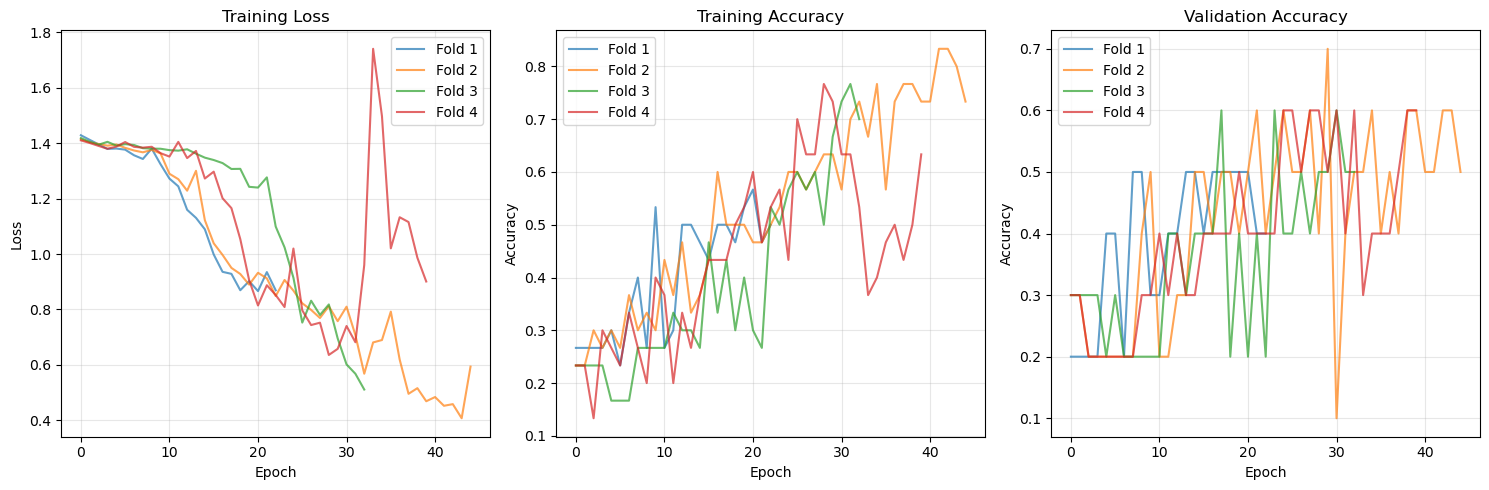

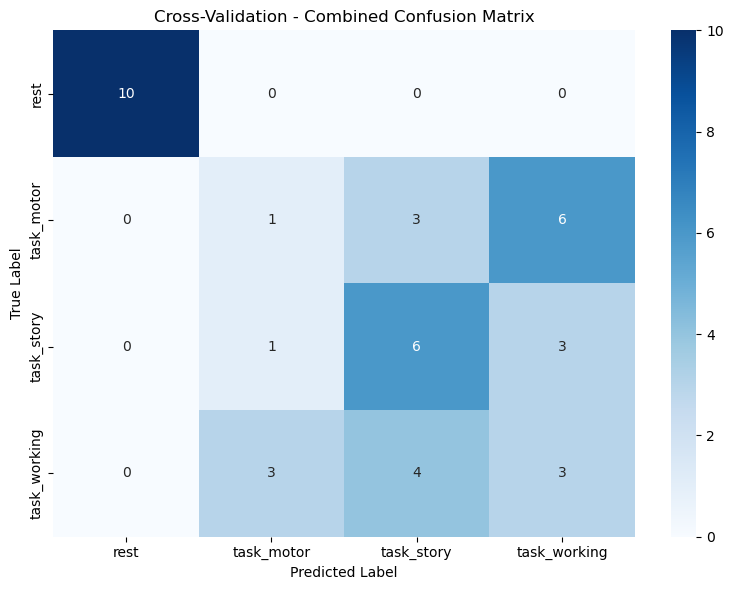


🎯 FINAL RESULT: 0.6000 ± 0.0707 (60.0% ± 7.1%)


In [68]:
all_data = train_data + test_data
all_labels = train_labels + test_labels

print(f"Starting cross-validation with {len(all_data)} total samples...")
print(f"Label distribution: {dict(zip(*np.unique(all_labels, return_counts=True)))}")

# Run cross-validation experiment
fold_results, all_histories = cross_validation_experiment(
    all_data, all_labels, LABEL_MAP, 
    n_splits=4, epochs=50, batch_size=2  # Small batch size for small dataset
)

# Analyze results
mean_acc, std_acc = analyze_cv_results(fold_results, all_histories, LABEL_MAP)

print(f"\n🎯 FINAL RESULT: {mean_acc:.4f} ± {std_acc:.4f} ({mean_acc*100:.1f}% ± {std_acc*100:.1f}%)")